In [117]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [7]:
chars = sorted(set(''.join(words)))
n2i = {s:i+1 for i, s in enumerate(chars)}
n2i['.'] = 0
i2n = {i: s for s, i in n2i.items()}
n2i

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [423]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {str(maxdiff):5s}')

In [306]:
def build_dataset(words):
    X, Y = [], []
    block_size = 3
    for w in words:
        context = [0]*block_size

        for ch in w+'.':
            idx = n2i[ch]
            X.append(context)
            Y.append(idx)
            #print(''.join(i2n[i] for i in context), '-->', i2n[idx])
            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, y_train = build_dataset(words[:n1])
X_val, y_val = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])


In [ ]:
n_emb = 20
n_hidden = 200
block_size = 3
vocab_size = 27


g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3)/((n_emb * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bmean_running = torch.zeros((1, n_hidden))*0.1 + 1.0
bstd_running = torch.ones((1, n_hidden))*0.1

parameters = [C, W1, W2, b2, bngain, bnbias]

In [362]:
sum(p.nelement() for p in parameters)

18567

In [ ]:
for p in parameters:
    p.requires_grad = True

# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre

# lris = []
losses = []
stepi = []

In [ ]:

for i in range(200000):
    #mini-batch
    idx = torch.randint(0, X_train.shape[0], (128, ))

    
    #forward pass
    emb = C[X_train[idx]]
    h_preact = emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 #+ b1
    bmeani = h_preact.mean(0, keepdim=True)
    bstdi = h_preact.std(0, keepdim=True)
    h_preact = (h_preact - bmeani) / (bstdi)
    h_preact = bngain * h_preact + bnbias
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[idx])

    with torch.no_grad():
        bmean_running = 0.999 * bmean_running + 0.001 * bmeani
        bstd_running = 0.999 * bstd_running + 0.001 * bstdi

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # lris.append(lr)
    stepi.append(i)
    losses.append(loss.log10().item())
    
    #print(loss.item())

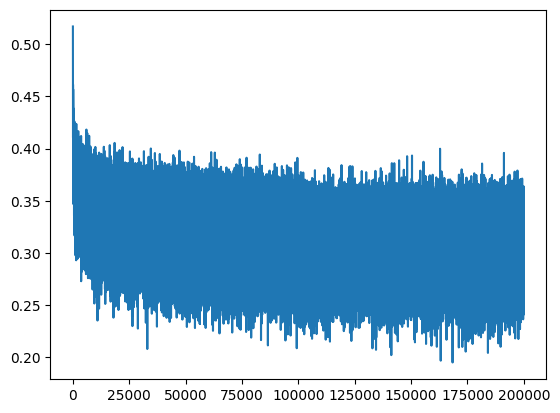

In [367]:
plt.plot(stepi, losses)

In [ ]:
emb = C[X_train]
h_preact = emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 #+ b1
h_preact = (h_preact - bmean_running) / (bstd_running)
h_preact = bngain * h_preact + bnbias
h = torch.tanh(h_preact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
loss

tensor(1.9891, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[X_val]
h_preact = emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 #+ b1
h_preact = (h_preact - bmean_running) / (bstd_running)
h_preact = bngain * h_preact + bnbias
h = torch.tanh(h_preact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_val)
loss

tensor(2.0816, grad_fn=<NllLossBackward0>)

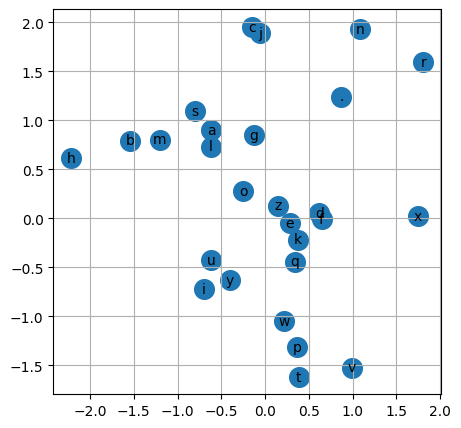

In [370]:
plt.figure(figsize=(5, 5))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), i2n[i], ha='center', va='center')
plt.grid('minor')

In [373]:
block_size = 3
g = torch.Generator().manual_seed(42)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h_preact = emb.view(1, -1) @ W1        # (1, n_hidden)
        # Используем running-статистики и gain/bias
        h_preact = (h_preact - bmean_running) / (bstd_running)
        h_preact = bngain * h_preact + bnbias
        h = torch.tanh(h_preact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break
    print(''.join([i2n[i] for i in out[:-1]]))


anuellyvion
marian
dan
shan
silayler
kemarce
man
epiacelle
jamee
kendrijondre
kalla
mikolynn
acvionne
chalivianar
tiyan
mar
tal
selayo
dakoton
ker


# Torchifying code

In [420]:
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.weight = torch.randn((in_features, out_features), generator=g) / in_features**0.5
        self.bias = torch.zeros(out_features) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, num_features, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)

        self.running_mean = torch.zeros(num_features)
        self.running_std = torch.ones(num_features)
    

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xstd = x.std(0, keepdim=True)
        else:
            xmean = self.running_mean
            xstd = self.running_std
        
        xhat = (x - xmean) / torch.sqrt(xstd + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.momentum + self.gamma * xmean
                self.running_std = (1 - self.momentum) * self.momentum + self.gamma * xstd
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [421]:
n_emb = 10
n_hidden = 200
g = torch.Generator().manual_seed(42)

C = torch.randn((vocab_size, n_emb), generator=g)
layers = [
    Linear(n_emb * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    layers[-1].gamma *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True
(sum(p.nelement() for p in parameters))

173724

In [422]:
steps = 200_000
batch_size = 32
stepi = []
losses = []

for i in range(steps):
    idx = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, yb = X_train[idx], y_train[idx]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, yb)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    
    if i % 10000 == 0:
        print(f'{i}/{steps} - loss:{loss}')
    losses.append(loss.log10().mean())
    stepi.append(i)

0/200000 - loss:3.2962160110473633
10000/200000 - loss:2.0349366664886475
20000/200000 - loss:2.4575960636138916
30000/200000 - loss:1.9628902673721313
40000/200000 - loss:2.1544549465179443
50000/200000 - loss:2.491018295288086
60000/200000 - loss:2.144200563430786
70000/200000 - loss:2.2075436115264893
80000/200000 - loss:1.6946940422058105
90000/200000 - loss:1.9482702016830444
100000/200000 - loss:2.0255675315856934
110000/200000 - loss:2.0570502281188965
120000/200000 - loss:2.0439581871032715
130000/200000 - loss:2.1676084995269775
140000/200000 - loss:1.868528127670288
150000/200000 - loss:2.3705451488494873
160000/200000 - loss:1.9325522184371948
170000/200000 - loss:1.8951959609985352
180000/200000 - loss:2.0798704624176025
190000/200000 - loss:2.159965753555298
